### Stock Price Prediction Using LSTM

In [ ]:
# #first, import data from url...
# import requests

# url = "https://raw.githubusercontent.com/pierpaolo28/Data-Visualization/master/Dash/stock_data.csv"

# response = requests.get(url)

# if response.status_code == 200:

#     with open("stock_data.csv", "wb") as file:
#         print(response)
#         file.write(response.content)
#     print("file downloading succeed")
# else:
#     print("download failed: status code", response.status_code)


<Response [200]>
file downloading succeed


In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
 %cd '/content/drive/MyDrive/StockPricePrediction/'

/content/drive/MyDrive/StockPricePrediction


In [9]:
data = pd.read_csv('stock_data.csv')
data

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL
...,...,...,...,...,...,...,...,...
19581,2017-11-06,178.56000,180.45000,178.31000,180.17000,13275578,0,FB
19582,2017-11-07,180.50000,180.74800,179.40300,180.25000,12903836,0,FB
19583,2017-11-08,179.79000,180.35000,179.11000,179.56000,10467606,0,FB
19584,2017-11-09,178.31000,179.40000,177.09000,179.30000,12602188,0,FB


In [10]:
df = data[data['Stock']=='AAPL']
df

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL
...,...,...,...,...,...,...,...,...
8359,2017-11-06,171.75000,174.36000,171.10000,173.63000,34901241,0,AAPL
8360,2017-11-07,173.29000,174.51000,173.29000,174.18000,24424877,0,AAPL
8361,2017-11-08,174.03000,175.61000,173.71000,175.61000,24451166,0,AAPL
8362,2017-11-09,174.48000,175.46000,172.52000,175.25000,29533086,0,AAPL


<ipython-input-11-8173736ad596>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df.Date, format = "%Y-%m-%d")


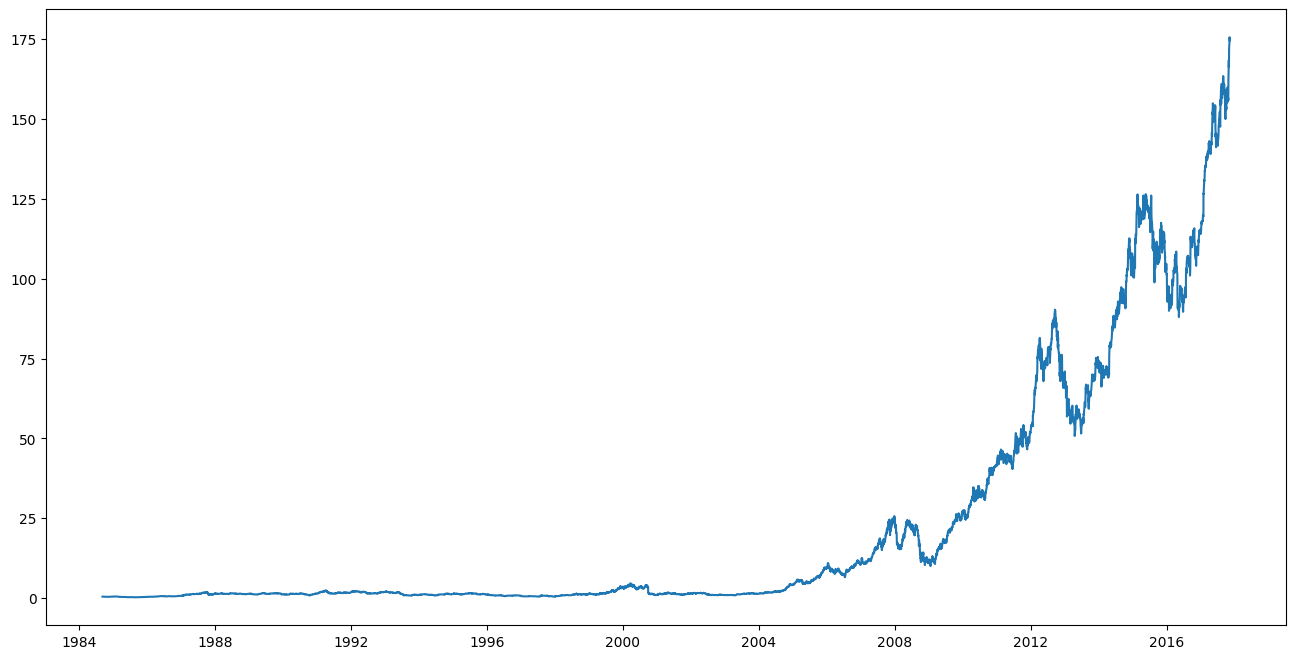

In [11]:
df['Date'] = pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.index = df['Date']
plt.figure(figsize = (16, 8))
plt.plot(df['Close'], label = 'Close Price History')

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [21]:
data = df.sort_index(ascending = True, axis = 0)
new_dataset = pd.DataFrame(index = range(0,len(df)),columns = ['Date','Close'])

for i in range(0,len(df)):
  new_dataset['Date'][i] = data['Date'][i]
  new_dataset['Close'][i] = data['Close'][i]

In [22]:
# Normalize the new_dataset into data rnage between (0,1)
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min
new_dataset.index = new_dataset['Date']
new_dataset.drop('Date',axis = 1, inplace = True)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(new_dataset.values)

total_len = scaled_data.shape[0]
train_size = int(total_len * 0.7)

train_data = scaled_data[:train_size]
valid_data = scaled_data[train_size:]

# Rolling Window :: we use 60 previous data for prediction of tommorrow
X_train, y_train = [], []
for i in range (60, len(train_data)):
  X_train.append(scaled_data[i-60:i,0])
  y_train.append(scaled_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

### Modeling & Training

In [28]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dense(1))

inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
lstm_model.fit(X_train, y_train, epochs =1, batch_size =1, verbose = 2)

5794/5794 - 240s - loss: 1.8451e-05 - 240s/epoch - 41ms/step


In [30]:
X_test = []
for i in range(60,inputs_data.shape[0]):
  X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

79/79 [==============================] - 4s 26ms/step


<ipython-input-33-71f5b43ae5b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price


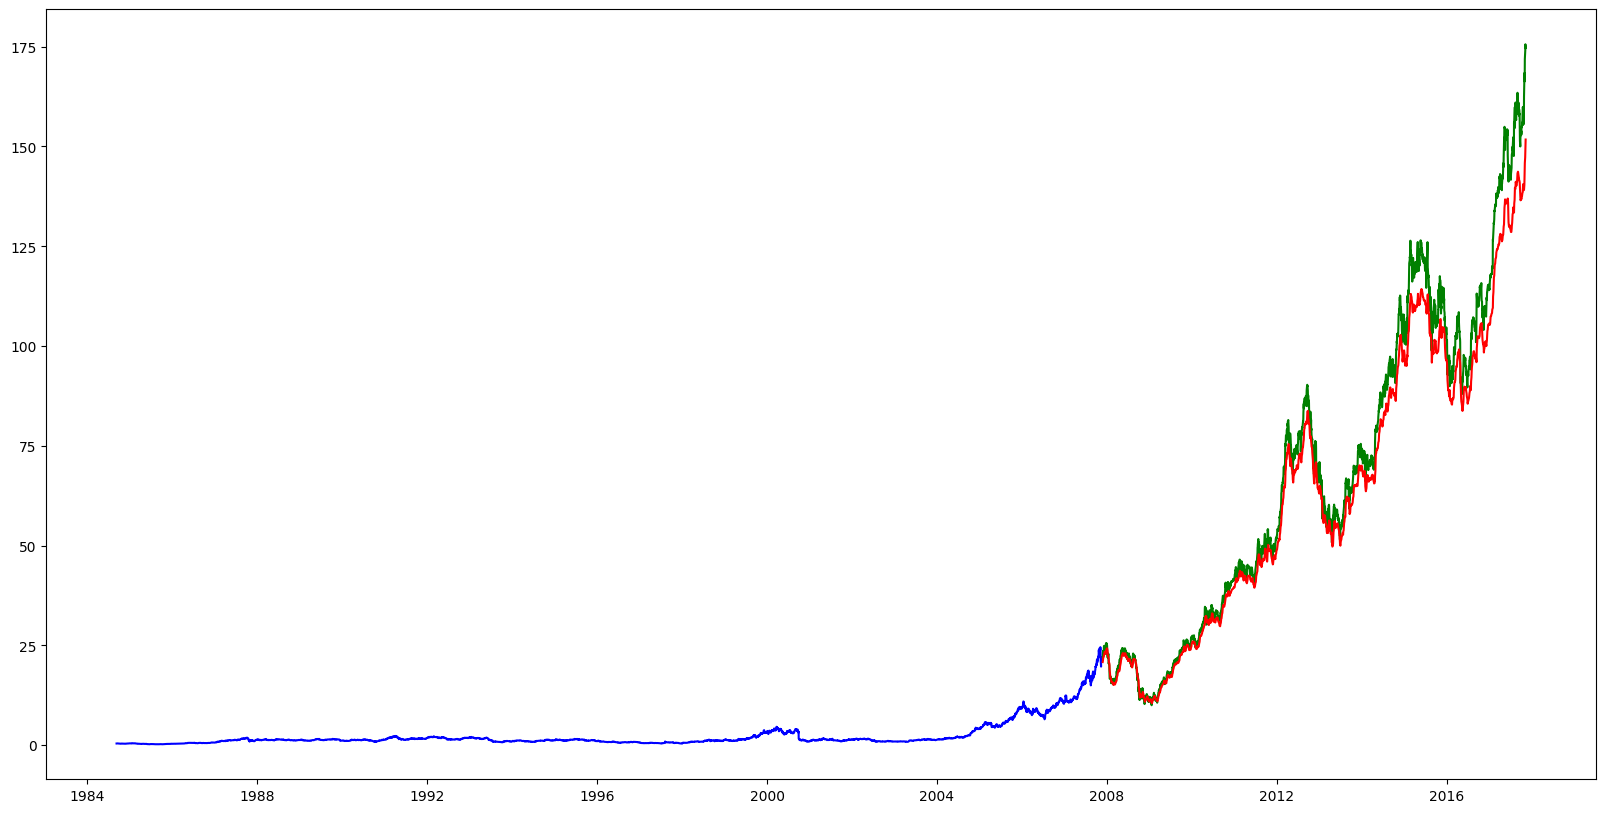

In [33]:
train_data = new_dataset[:train_size]
valid_data = new_dataset[train_size:]
valid_data['Predictions'] = predicted_closing_price
plt.plot(train_data['Close'],color = 'blue')
plt.plot(valid_data['Close'],color = 'green')
plt.plot(valid_data['Predictions'],color = 'red')